## ARIMA Model

In [20]:
import sys
# Make sure jupyter python path is set to root of the project directory
sys.path.insert(1, "/Users/ratikiyer/Documents/UIUC/IMC/imc_trading_2024")
import os
from packages.logger import Logger as logger
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np

%cd ..

/Users/ratikiyer/Documents/UIUC/IMC


##### Phase 1: create and fit ARIMA model to test data

In [3]:
df = pd.read_csv("./data/tutorial_data.csv", delimiter=";")
starfruit_price_action = df[(df["product"] == "STARFRUIT")]
amethysts_price_action = df[(df["product"] == "AMETHYSTS")]

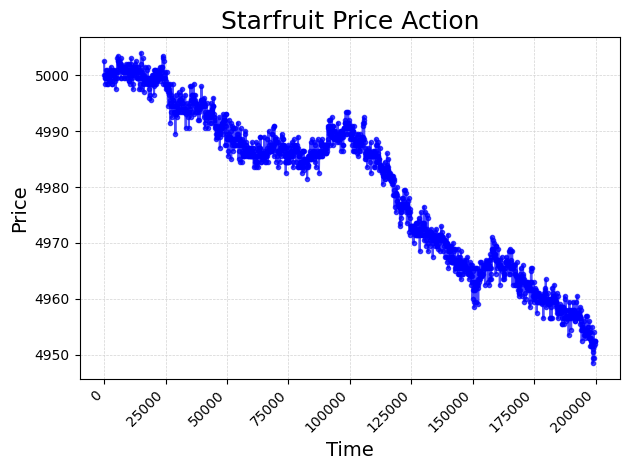

In [4]:
timestamps = starfruit_price_action["timestamp"]
starfruit_price = starfruit_price_action["mid_price"]
plt.plot(timestamps, starfruit_price, marker='o', linestyle='-', color='blue', alpha=0.7, markersize=3)
plt.xticks(color='black', rotation=45, ha='right')
plt.yticks(color='black')
plt.title('Starfruit Price Action', fontsize=18)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.grid(color='lightgray', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

<Figure size 1400x500 with 0 Axes>

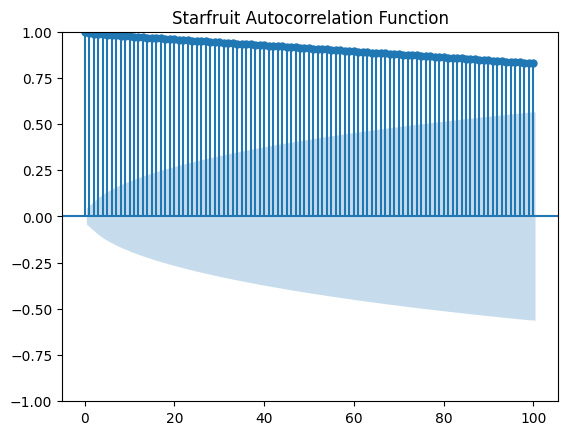

<Figure size 1400x500 with 0 Axes>

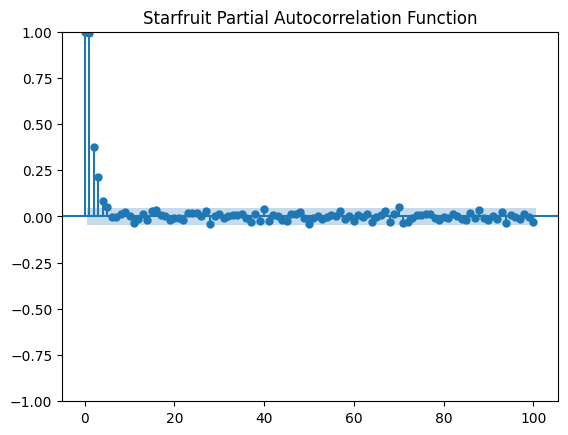

In [5]:
plt.figure(figsize=(14, 5))
plot_acf(starfruit_price, lags=100, alpha=0.05)
plt.title('Starfruit Autocorrelation Function')

plt.show()

plt.figure(figsize=(14, 5))
plot_pacf(starfruit_price, lags=100, alpha=0.05)
plt.title('Starfruit Partial Autocorrelation Function')

plt.show()

##### In the plot above we see that the last 4 prices are the most important to the model (cache size should be 4)

In [8]:
# Fit ARIMA model
starfruit_model = ARIMA(starfruit_price.reset_index(drop=True), order=(1, 1, 1))
arima_starfruit = starfruit_model.fit()

# Summary of the model
print(arima_starfruit.summary())

# Make forecast
print("Forecasting Results:")
forecast = arima_starfruit.forecast(steps=3)
print(forecast)

                               SARIMAX Results                                
Dep. Variable:              mid_price   No. Observations:                 2000
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3437.136
Date:                Wed, 03 Apr 2024   AIC                           6880.273
Time:                        16:15:24   BIC                           6897.074
Sample:                             0   HQIC                          6886.442
                               - 2000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0221      0.028      0.788      0.431      -0.033       0.077
ma.L1         -0.7468      0.019    -38.859      0.000      -0.784      -0.709
sigma2         1.8232      0.046     39.730      0.0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressiv

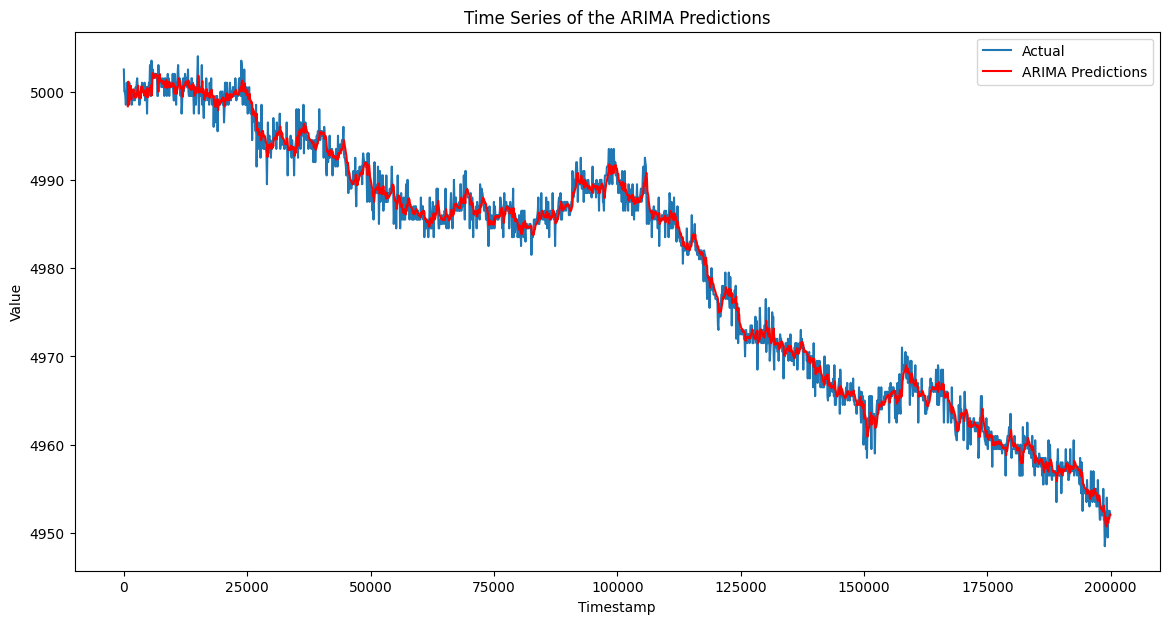

In [28]:
arima_starfruit = starfruit_price_action.copy()
arima_starfruit["ARIMA_Prediction"] = None
#arima_starfruit.index = pd.to_datetime(starfruit_price_action["timestamp"])
for end in range(8, len(df)):
    # Train the model on data up to the current point
    model = ARIMA(starfruit_price_action["mid_price"][:end], order=(4,1,1))  # Replace with your chosen order
    model_fit = model.fit()
    
    # Make the one-step-ahead forecast
    forecast = model_fit.forecast(steps=1)

    if end < len(starfruit_price_action):
        arima_starfruit.loc[arima_starfruit.index[end], 'ARIMA_Prediction'] = forecast.iloc[0]
    else:
        break

plt.figure(figsize=(14, 7))
plt.plot(arima_starfruit["timestamp"], starfruit_price_action["mid_price"], label='Actual')
plt.plot(arima_starfruit['timestamp'], arima_starfruit["ARIMA_Prediction"], color='red', label='ARIMA Predictions')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Time Series of the ARIMA Predictions')
plt.legend()
plt.show()

In [30]:
# First order differencing
# print(arima_starfruit.head())
# arima_starfruit["diff1"][8:len(arima_starfruit)] = arima_starfruit["mid_price"][8:len(arima_starfruit)].diff()

# Drop the NaN values that this operation creates at the beginning of the series
#arima_starfruit = arima_starfruit.dropna()

# Perform the Dickey-Fuller test on your time series data
adf_result = adfuller(arima_starfruit["mid_price"])

print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

# If the p-value is less than 0.05, we reject the null hypothesis
# (the data does not have a unit root and is stationary)
# If not, the data is non-stationary and needs to be differenced

ADF Statistic: 0.285317
p-value: 0.976661
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [19]:
arima_starfruit.tail()

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss,ARIMA_Prediction
timestamp,,,,,,,,,,,,,,,,,,
1970-01-01 00:00:00.000199500,-2,199500,STARFRUIT,4949,23,NaN,NaN,NaN,NaN,4956,23,NaN,NaN,NaN,NaN,4952.5,586.664062,4951.142881
1970-01-01 00:00:00.000199600,-2,199600,STARFRUIT,4949,22,NaN,NaN,NaN,NaN,4956,22,NaN,NaN,NaN,NaN,4952.5,584.703125,4951.532574
1970-01-01 00:00:00.000199700,-2,199700,STARFRUIT,4949,27,NaN,NaN,NaN,NaN,4956,27,NaN,NaN,NaN,NaN,4952.5,585.039062,4951.612057
1970-01-01 00:00:00.000199800,-2,199800,STARFRUIT,4949,21,NaN,NaN,NaN,NaN,4956,21,NaN,NaN,NaN,NaN,4952.5,588.945312,4951.937021
1970-01-01 00:00:00.000199900,-2,199900,STARFRUIT,4950,32,NaN,NaN,NaN,NaN,4954,7,4956.0,32.0,NaN,NaN,4952.0,591.031250,4952.100487


In [ ]:
# timestamps = amethysts_price_action["timestamp"]
# amethyst_price = amethysts_price_action["mid_price"]
# plt.plot(timestamps, amethyst_price, marker='o', linestyle='-', color='blue', alpha=0.7, markersize=3)
# plt.xticks(color='black', rotation=45, ha='right')
# plt.yticks(color='black')
# plt.title('Amethyst Price Action', fontsize=18)
# plt.xlabel('Time', fontsize=14)
# plt.ylabel('Price', fontsize=14)
# plt.grid(color='lightgray', linestyle='--', linewidth=0.5)
# plt.tight_layout()
# plt.show()